n01641577

0.038738*agama * newt_0.7465035.jpg


In [59]:
import torchvision

image = torchvision.io.read_image(
    "datasets/imagenet-a/n01641577/0.038738_agama _ newt_0.7465035.jpg"
)

# image_batch = image.float().div(255).unsqueeze(0).repeat(63, 1, 1, 1)
image_batch = image.float().div(255).repeat(63, 1, 1, 1)

In [63]:
import torch
import kornia.augmentation as K
import numpy as np
from typing import List, Optional
from torch import nn
import kornia.enhance as Ke


class AugMixKornia:
    def __init__(
        self,
        severity: int = 3,
        width: int = 3,
        depth: int = -1,
        alpha: float = 1.0,
        mixture_width: int = 3,
        chain_depth: int = 3,
        all_ops: bool = True,
        device: Optional[str] = None,
    ):
        """
        AugMix implementation using Kornia with closer fidelity to the original paper.
        
        Args:
            severity: Severity level of augmentations (1-10)
            width: Width of augmentation chain (not used directly, kept for compatibility)
            depth: Depth of augmentation chain (-1 for random between 1-3)
            alpha: Dirichlet distribution parameter for mixing weights
            mixture_width: Number of augmentation chains to mix
            chain_depth: Number of operations in each chain
            all_ops: Whether to use all augmentation operations
            device: Device to run on (cuda/cpu)
        """
        self.severity = severity
        self.alpha = alpha
        self.mixture_width = mixture_width
        self.chain_depth = chain_depth if depth <= 0 else depth
        self.all_ops = all_ops
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")

        # Define augmentation operations
        self.augmentations = self._get_augmentations()

    def _get_augmentations(self) -> List[nn.Module]:
        """Create a list of augmentation operations that will be randomly applied"""
        severity_factor = self.severity / 10.0

        if self.all_ops:
            # Full set of augmentations similar to original AugMix
            return [
                # AutoContrast
                K.ColorJitter(brightness=0.1*self.severity, contrast=0.1*self.severity, p=1.0),
                
                # Equalize
                Ke.equalize,
                
                # Posterize
                K.RandomPosterize(bits=max(1, 8 - self.severity), p=1.0),
                
                # Rotate
                K.RandomRotation(degrees=(-30 * severity_factor, 30 * severity_factor), p=1.0),
                
                # Solarize
                K.RandomSolarize(thresholds=0.5, additions=(0.0, 0.1 * self.severity), p=1.0),
                
                # Shear
                K.RandomAffine(degrees=0, shear=(-15 * severity_factor, 15 * severity_factor), p=1.0),
                
                # Translate
                K.RandomAffine(degrees=0, translate=(0.1 * severity_factor, 0.1 * severity_factor), p=1.0),
                
                # ColorJitter
                K.ColorJitter(brightness=0.1*self.severity, contrast=0.1*self.severity, 
                            saturation=0.1*self.severity, hue=0.1, p=1.0),
            ]
        else:
            # Simplified version
            return [
                K.ColorJitter(brightness=0.1*self.severity, contrast=0.1*self.severity, p=1.0),
                Ke.equalize,
                K.RandomAffine(degrees=(-15 * severity_factor, 15 * severity_factor), p=1.0),
            ]

    def _apply_augmentation_chain(self, image: torch.Tensor) -> torch.Tensor:
        """
        Apply a random sequence of augmentations to an image.
        
        Args:
            image: Input image tensor (C, H, W)
            
        Returns:
            Augmented image tensor (C, H, W)
        """
        # Randomly select augmentations for this chain
        op_indices = np.random.choice(
            len(self.augmentations), 
            size=self.chain_depth, 
            replace=True
        )
        
        # Apply augmentations in random order
        augmented = image.clone()
        for op_idx in op_indices:
            op = self.augmentations[op_idx]
            augmented = op(augmented.unsqueeze(0)).squeeze(0)
            
        return augmented

    def __call__(self, images: torch.Tensor) -> torch.Tensor:
        """
        Apply AugMix to a batch of images.
        
        Args:
            images: Input batch of images (B, C, H, W) or (C, H, W)
            
        Returns:
            Augmented batch (same shape as input)
        """
        # Input validation
        if not isinstance(images, torch.Tensor):
            images = K.image_to_tensor(images)

        if images.dim() == 3:
            images = images.unsqueeze(0)

        # Move to device if needed
        if images.device != self.device:
            images = images.to(self.device)

        batch_size = images.shape[0]
        
        # Sample mixing weights from Dirichlet distribution
        weights = torch.from_numpy(
            np.random.dirichlet([self.alpha] * self.mixture_width, size=batch_size)
        ).float().to(self.device)  # Shape (B, mixture_width)
        
        # Sample weights for mixing with original
        mix_weights = torch.from_numpy(
            np.random.dirichlet([self.alpha, self.alpha], size=batch_size)
        ).float().to(self.device)  # Shape (B, 2)

        # Generate augmented versions for each mixture component
        augmented = []
        for _ in range(self.mixture_width):
            batch_aug = torch.stack([
                self._apply_augmentation_chain(images[i]) 
                for i in range(batch_size)
            ])
            augmented.append(batch_aug)
        
        # Stack augmented versions (mixture_width, B, C, H, W)
        augmented = torch.stack(augmented)
        
        # Weighted sum of augmented versions
        mixed = torch.einsum('mbchw,bm->bchw', augmented, weights)
        
        # Final mix with original image
        result = mix_weights[:, 0:1, None, None] * images + \
                 mix_weights[:, 1:2, None, None] * mixed

        return result.squeeze(0) if result.shape[0] == 1 else result

In [66]:
kornia_augmix = AugMixKornia(severity=3, device="cuda", all_ops=True)
augmented_images = kornia_augmix(image_batch)

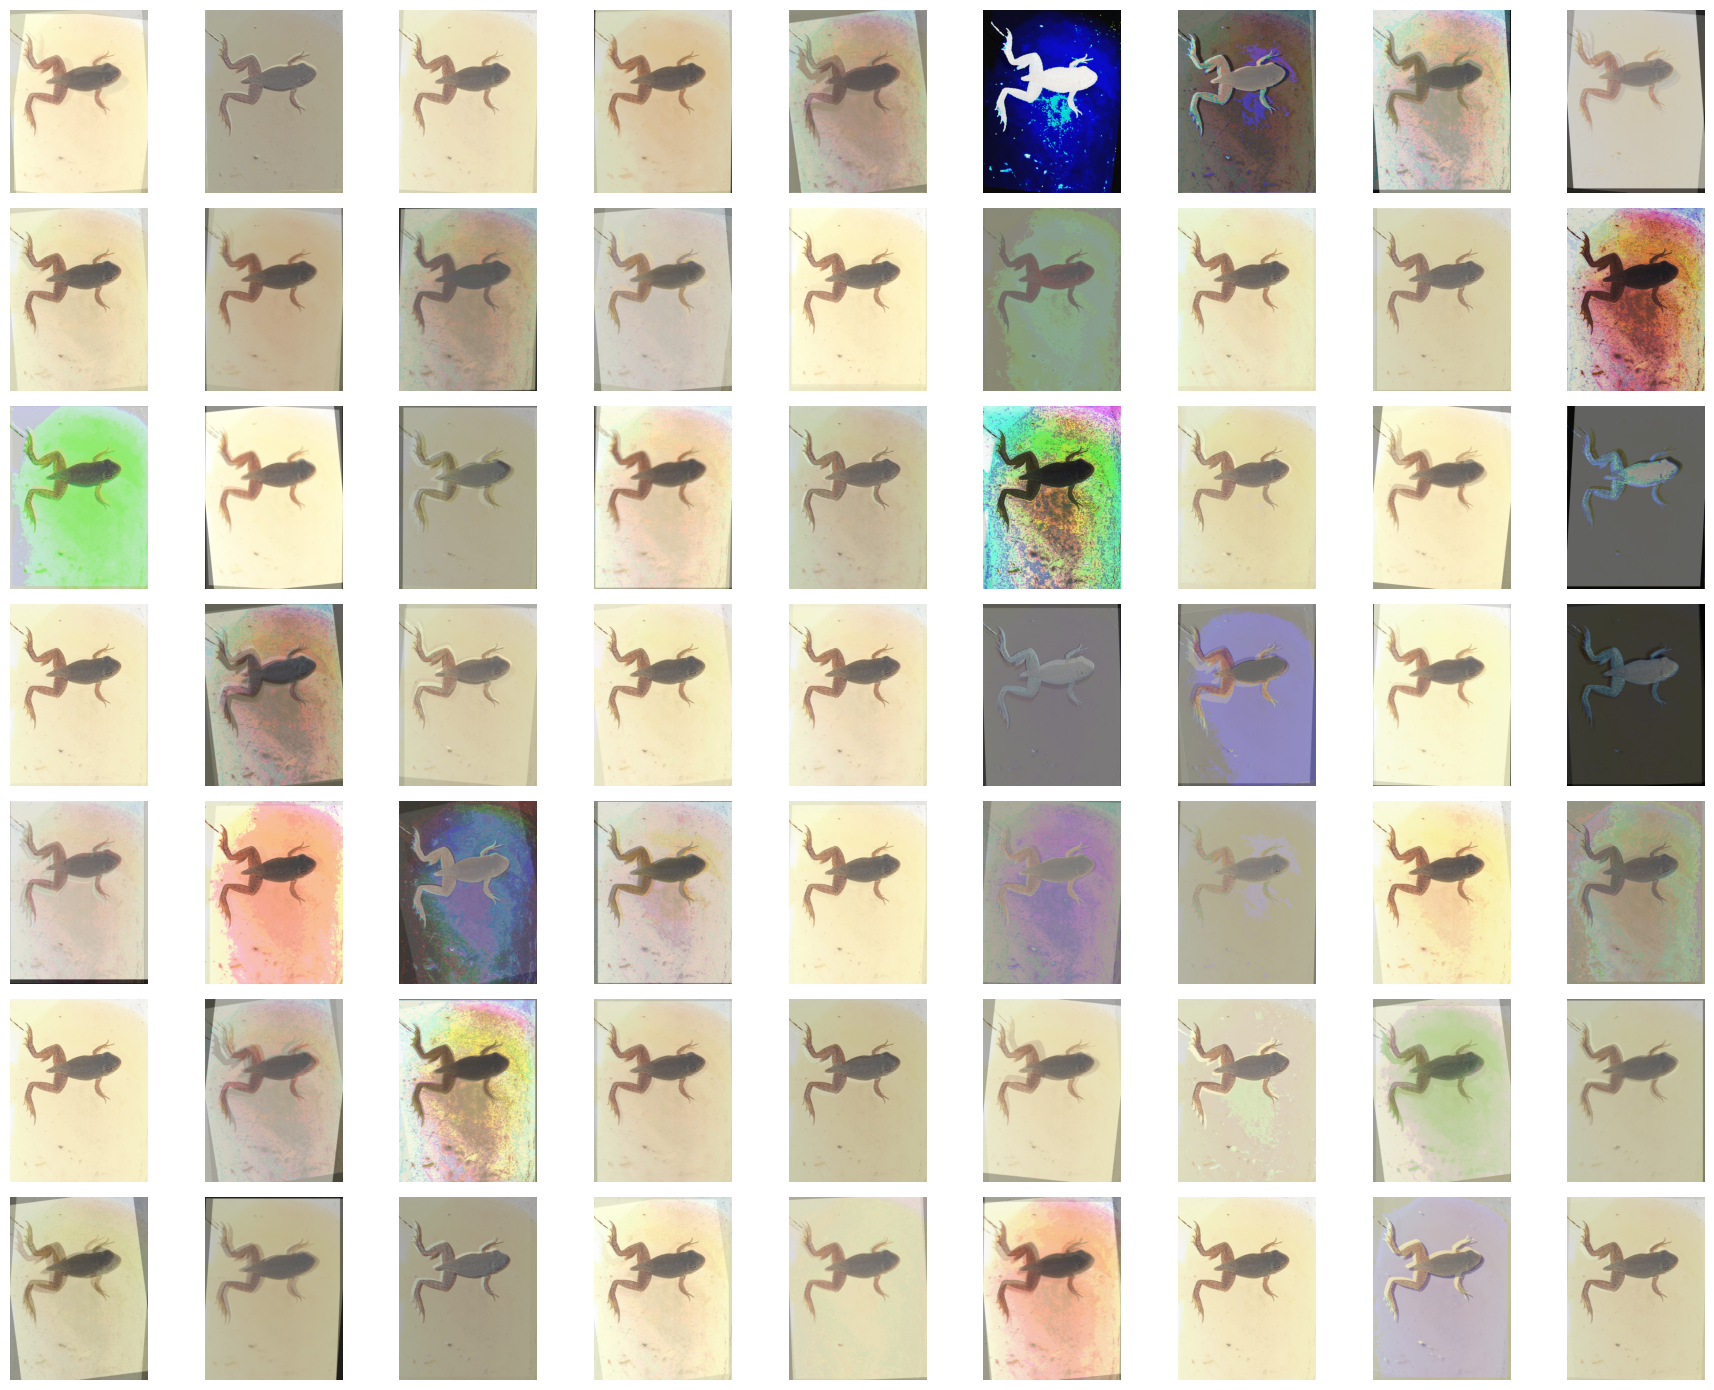

In [65]:
plot_images(augmented_images)

In [50]:
# Same on augmix
augmix = torchvision.transforms.AugMix()
augmented_augmix = [augmix(image) for _ in range(63)]
augmented_augmix = torch.stack(augmented_augmix)
augmented_augmix.shape

torch.Size([63, 3, 500, 375])

In [6]:
# visualize images

import torch
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF


def plot_images(images):
    cols = 9
    rows = (images.shape[0] + cols - 1) // cols

    plt.figure(figsize=(cols * 2, rows * 2))
    for i in range(images.shape[0]):
        img = images[i]
        img = TF.to_pil_image(img)  # Convert from [C, H, W] to PIL image

        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

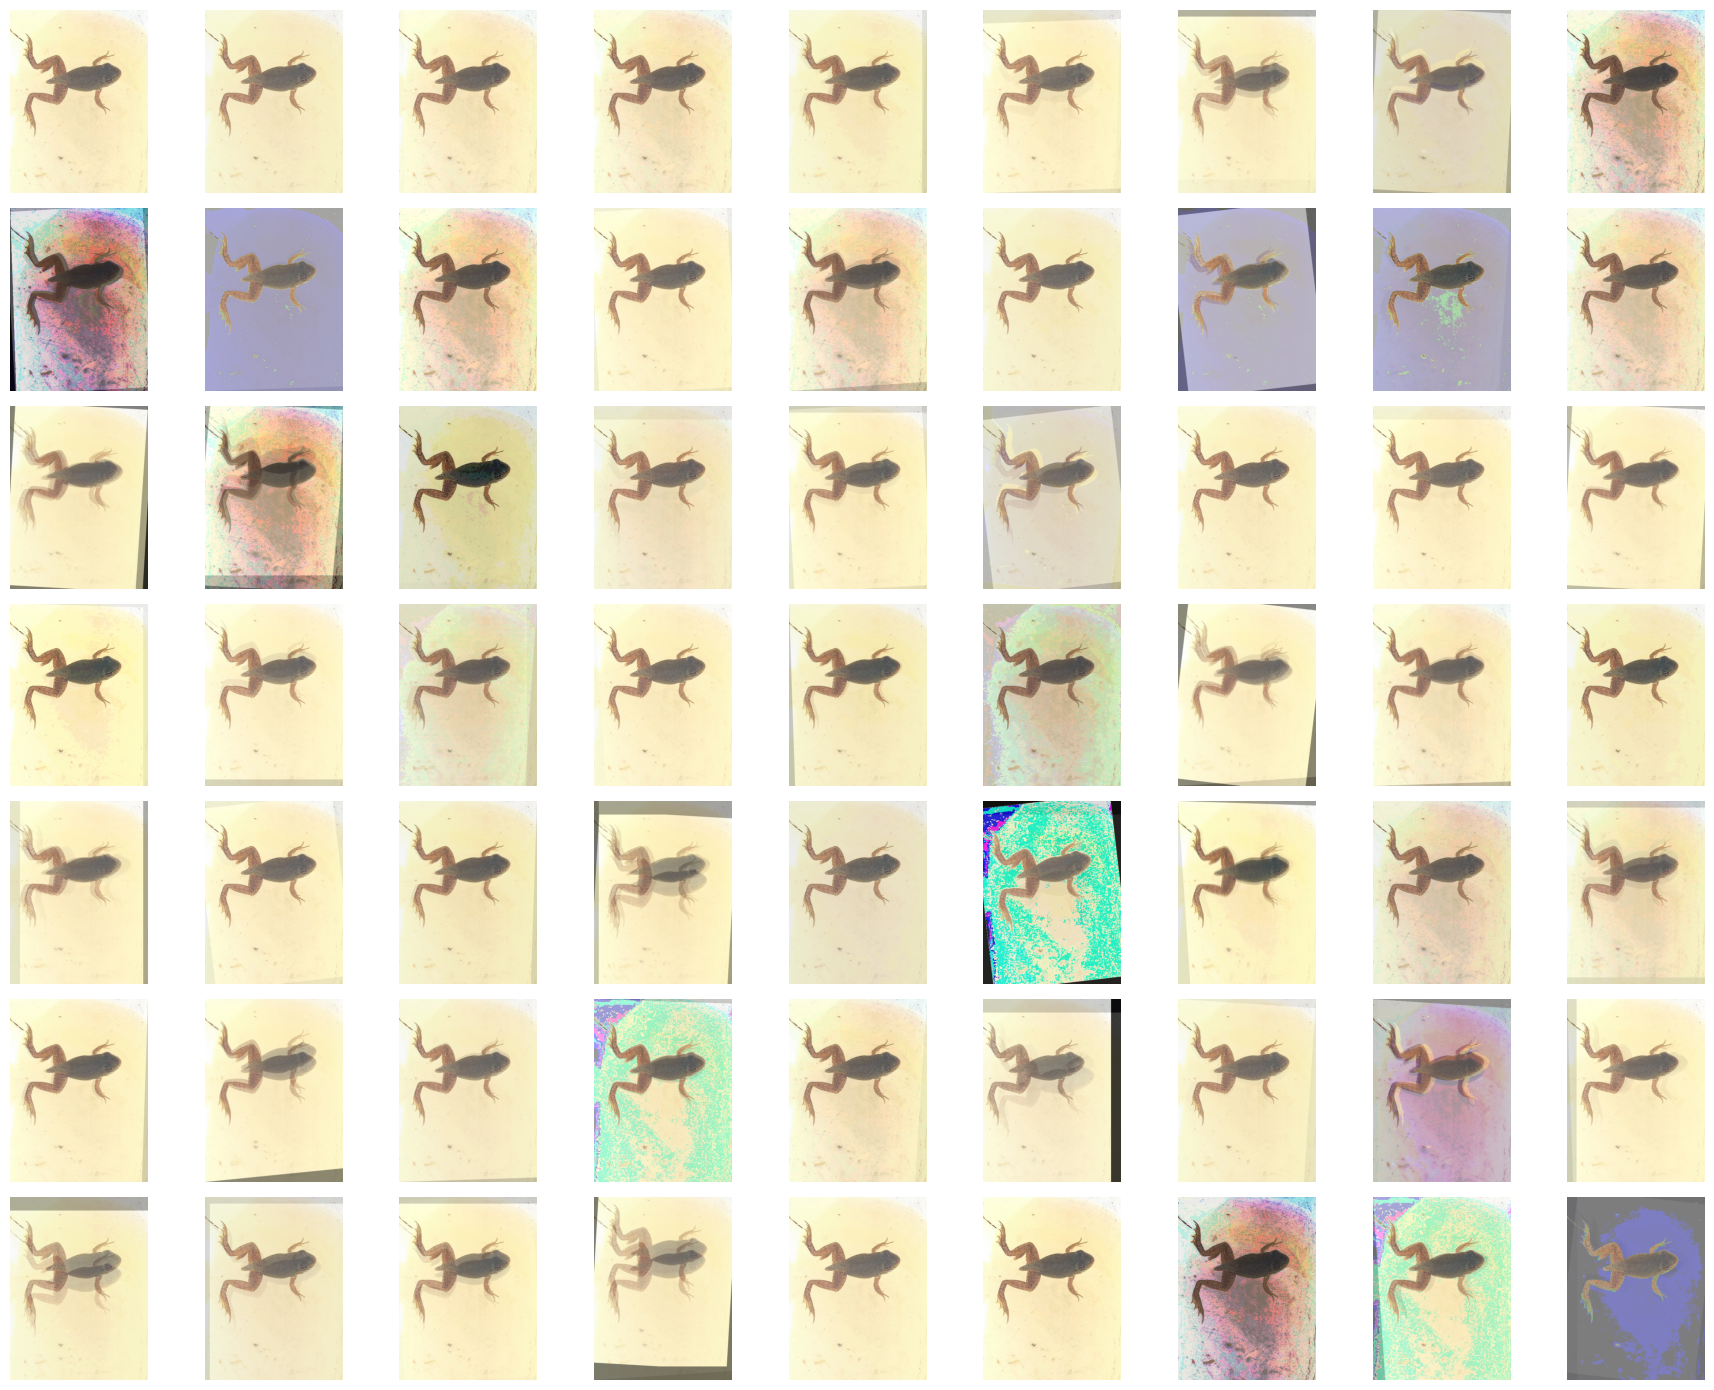

In [28]:
plot_images(augmented_augmix)